In [1]:
import uproot
import pandas as pd
import numpy as np
from tqdm import tqdm
from matplotlib.colors import LogNorm

In [2]:
import matplotlib.pyplot as plt

In [3]:
infile_name = ('/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0001.root')
infile = uproot.open(infile_name)
event_dir=infile['events']
events = infile['events']["events"]

In [4]:
keys = infile.keys()

print(keys)

['G4VERSION_TAG;1', 'events;1', 'events/nbevents;1', 'events/events;1', 'G4RUNTIME;1', 'RANDOM_SEED;1']


In [5]:
primaries = infile["events"]["nbevents"]
primaries.value

10000

In [6]:
def read_root_dir_minimal(fn, treename='events', output_type='df', istart=0, istop=1000):
    '''
    Output types can be 'df' for pandas dataframe or 'array' for numpy array.
    '''
    with uproot.open(fn) as f:
        tree = f[f"{treename}"][f"{treename}"]
        branches = ['nsteps', 'xp', 'yp', 'zp', 'PreStepEnergy', 'etot', 'parentid', 'parenttype', 'xp_pri', 'yp_pri', 'zp_pri', 'ed', 'time']
        data = tree.arrays(branches, filter_name='nsteps', library='np', entry_start = istart, entry_stop=istop)
        
        # Apply selection: NAct > 0
        mask = data['nsteps'] >= 0
        filtered_data = {key: value[mask] for key, value in data.items()}
        
        if output_type == 'df':
            return pd.DataFrame(filtered_data)
        elif output_type == 'array':
            return filtered_data
        else:
            print(f'Warning: output type you specified is {output_type}, not understood, returning numpy array...')
            return filtered_data

In [7]:
row_length = ('nsteps')
scalar_fields = ['etot', 'xp_pri', 'yp_pri', 'zp_pri']
vector_fields = ['xp', 'yp', 'zp', 'PreStepEnergy', 'parentid', 'parenttype', 'ed', 'time']

def flatten_mc_tree(df, row_length=row_length, vector_fields=vector_fields, scalar_fields=scalar_fields):
    flattened_data = []
    for i, row in df.iterrows():
        # Check lengths just in case
        assert row[row_length] == len(row[vector_fields[0]])

        for j in range(row[row_length]):
            new_row = {}
            new_row['event'] = i
            new_row['particle'] = j

            for key in scalar_fields:
                new_row[key] = row[key]

            for key in vector_fields:
                new_row[key] = row[key][j]

            flattened_data.append(new_row)
   
    df_flattend = pd.DataFrame(flattened_data)
    df_flattend.set_index(['event', 'particle',])  # MultiIndex

    return df_flattend

In [8]:
def process_chunk(df):
    xpos = []
    ypos = []
    zpos = []
    multis = []
    escatter=[]
    
    events = np.unique(df['event'])
    for event in events[:]:
        mask = ((df['event']==event) & (df['ed']>0))
        df_event = df[mask]
        xpos.append(np.average(df_event['xp'], weights = df_event['ed']))
        ypos.append(np.average(df_event['yp'], weights = df_event['ed']))
        zpos.append(np.average(df_event['zp'], weights = df_event['ed']))
        escatter.append(np.sum(df_event['ed']))
        multis.append(np.max(df_event['zp'])-np.min(df_event['zp'])>10)
        
    df_scatters = pd.DataFrame({'xpos':xpos,
                                'ypos':ypos,
                                'zpos':zpos,
                                'escatter':escatter,
                                'multis':multis})
    return df_scatters

In [9]:
def df_process_file(infile_name, treename='events', chunksize=1000, bstop=False, istop=-1):
    infile = uproot.open(infile_name)
    tree = infile[f"{treename}"][f"{treename}"]
    primaries = tree.arrays('etot')
    primaries = len(primaries)
    df_scatters =[]
    df_raw_all = []
    print(np.ceil(primaries/chunksize))
    for i_chunk in tqdm(range(int(np.ceil(primaries/chunksize)))):
        if bstop and (chunksize*i_chunk)>istop:
            break
        df_raw = read_root_dir_minimal(infile_name, treename, istart=chunksize*i_chunk, istop=chunksize*(i_chunk+1))
        df_flat = flatten_mc_tree(df_raw)
        df_flat = df_flat[df_flat['etot']>0]
        df_scatters.append(process_chunk(df_flat))
        df_raw_all.append(df_raw)
    df_scatters = pd.concat(df_scatters)
    df_raw_all =  pd.concat(df_raw_all)
    return df_scatters, df_raw_all

In [31]:
tree = infile['events']["events"]
primaries = tree.arrays('xp')

In [32]:
len(primaries)

3733

In [40]:
test_df, flat_df_raw = df_process_file(infile_name, treename='events', chunksize =100, bstop=True, istop =20000)

38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:30<00:00,  2.38s/it]


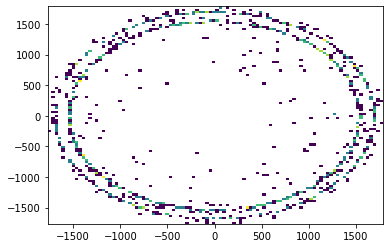

In [35]:
plt.hist2d(flat_df_raw['xp_pri'], flat_df_raw['yp_pri'],  bins=[100, 100], norm=LogNorm())
plt.show()

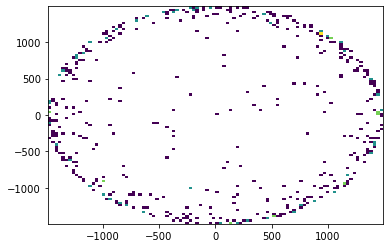

In [36]:
plt.hist2d(test_df['xpos'], test_df['ypos'],  bins=[100, 100], norm=LogNorm())
plt.show()

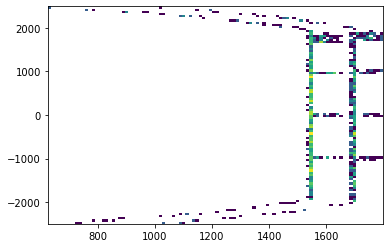

In [37]:
plt.hist2d(np.sqrt(flat_df_raw['xp_pri']**2+flat_df_raw['yp_pri']**2), flat_df_raw['zp_pri'],  bins=[100, 100], norm=LogNorm())
plt.show()

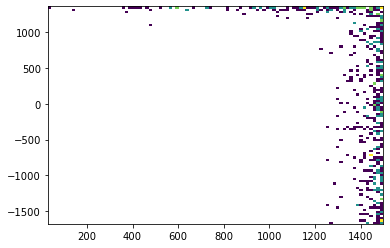

In [38]:
plt.hist2d(np.sqrt(test_df['xpos']**2+test_df['ypos']**2), test_df['zpos'],  bins=[100, 100], norm=LogNorm())
plt.show()

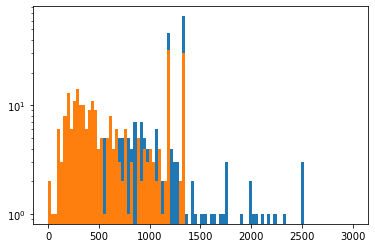

In [39]:
mask = (test_df['multis']==True)
plt.hist(test_df[mask]['escatter'], bins =np.linspace(0, 3000, 101), label = 'Multiscatter')
mask = (test_df['multis']==False)
plt.hist(test_df[mask]['escatter'], bins =np.linspace(0, 3000, 101), label = 'Singlescatter')
plt.yscale('log')
plt.show()

### Processed Background Files

In [69]:
test_df = np.load('analysis/test.npy', allow_pickle=True)
test_df = pd.DataFrame(test_df, columns=['xpos', 'ypos', 'zpos', 'escatter', 'multis'])

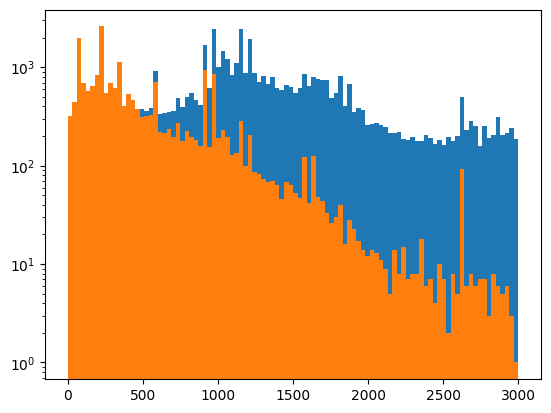

In [70]:
mask = (test_df['multis']==True)
plt.hist(test_df[mask]['escatter'], bins =np.linspace(0, 3000, 101), label = 'Multiscatter')
mask = (test_df['multis']==False)
plt.hist(test_df[mask]['escatter'], bins =np.linspace(0, 3000, 101), label = 'Singlescatter')
plt.yscale('log')
plt.show()

In [72]:
def energy_res(energy, a_res, b_res):
    resolution = a_res*np.sqrt(energy.values)+b_res*10**-3*energy
    e_smeared = np.random.normal(energy,resolution)
    return e_smeared

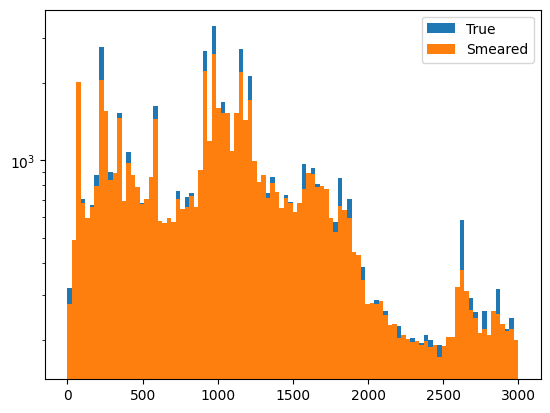

In [73]:
plt.hist(test_df['escatter'], bins =np.linspace(0, 3000, 101), label = 'True')
plt.hist(energy_res(test_df['escatter'].astype(float), 0.317, 1.7), bins =np.linspace(0, 3000, 101), label = 'Smeared')
plt.legend()
plt.yscale('log')
plt.show()

### Process All Background Runs

In [10]:
#in uBq/unit
act_dict = {'PMT': {'Co60': 700, 'U238': 8000, 'Th232': 500},
            'Sapphire': {'Co60': 0.0, 'U238': 90, 'Th232': 60},
            'PTFE': {'Co60': 50.0, 'U238': 150, 'Th232':50},
            #'Cryostat': {'Co60': 3000, 'U238': 4000, 'Th232':2000},
           }

mass_dict = {'PMT': 2364, 'Sapphire': 45, 'PTFE':200,} #'Cryostat': 4000}

def energy_res(energy, a_res, b_res):
    resolution = a_res*np.sqrt(energy.values)+b_res*10**-3*energy
    e_smeared = np.random.normal(energy,resolution)
    return e_smeared
    
max_index = 1000

In [11]:
scale_dict = {}
num_primaries_perfile = {'PMT': 100000, 'PTFE': 250000, 'Cryostat': 250000, 'Sapphire': 250000}
for key, volume in act_dict.items():
    volume_scale = {}
    for act_key, activity in volume.items(): 
        #print(act_key)
        if (act_dict[key][act_key])>0:
            scale_factor = num_primaries_perfile[key]/(mass_dict[key]*act_dict[key][act_key]*10e-6)
        else:
            scale_factor=0
        volume_scale[act_key] = scale_factor
        #print(scale_factor)
    scale_dict[key] = volume_scale

In [12]:
import glob
import os
import re
file_prefix = ''
all_dfs = []
all_raw_dfs=[]
key='Cryostat'
isotope='Co60'
# Search for all files matching the pattern for this key + isotope
file_pattern = f'/storage/xenon/jacquesp/hermeticTPC/{key}_{isotope}_*.root'
matched_files = sorted(glob.glob(file_pattern))

for filepath in matched_files:
    print(filepath)
    #filename = os.path.basename(filepath)

    # Use regex to extract serial number (handles zero-padding)
    #match = re.match(rf'{re.escape(file_prefix)}{re.escape(key)}_{re.escape(isotope)}_(\d+)\.npy', filename)
    #if match:
    #    serial_num = int(match.group(1))
    #    if serial_num > max_index:
    #        continue

    # Load and collect DataFrame
    #try:
    iso_vol_df, raw_dfs = df_process_file(filepath, treename='events', chunksize =100, bstop=True, istop =5000)
    #except:
    #print(filepath)
    #iso_vol_df = pd.DataFrame(iso_vol_df, columns=['xpos', 'ypos', 'zpos', 'escatter', 'multis'])
    all_dfs.append(iso_vol_df)
    all_raw_dfs.append(raw_dfs)

/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0001.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:30<00:00,  2.38s/it]


/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0002.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:31<00:00,  2.42s/it]


/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0003.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:38<00:00,  2.58s/it]


/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0004.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:37<00:00,  2.56s/it]


/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0005.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:34<00:00,  2.49s/it]


/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0006.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:32<00:00,  2.45s/it]


/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0007.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:32<00:00,  2.44s/it]


/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0008.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:33<00:00,  2.46s/it]


/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0009.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:33<00:00,  2.45s/it]


/storage/xenon/jacquesp/hermeticTPC/Cryostat_Co60_0010.root
38.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 38/38 [01:33<00:00,  2.47s/it]


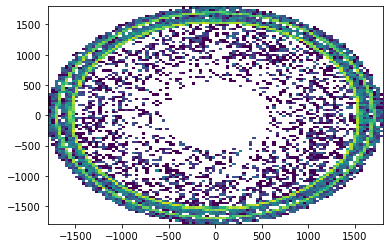

In [14]:
flat_df_raw =  pd.concat(all_raw_dfs)
plt.hist2d(flat_df_raw['xp_pri'], flat_df_raw['yp_pri'],  bins=[100, 100], norm=LogNorm())
plt.show()

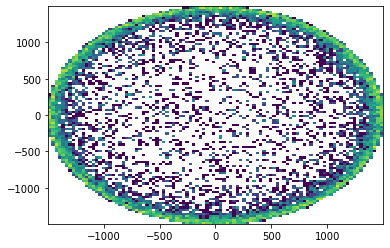

In [15]:
test_df =  pd.concat(all_dfs)
plt.hist2d(test_df['xpos'], test_df['ypos'],  bins=[100, 100], norm=LogNorm())
plt.show()

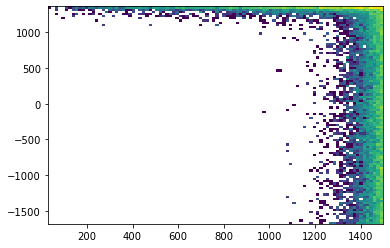

In [16]:
plt.hist2d(np.sqrt(test_df['xpos']**2+test_df['ypos']**2), test_df['zpos'],  bins=[100, 100], norm=LogNorm())
plt.show()

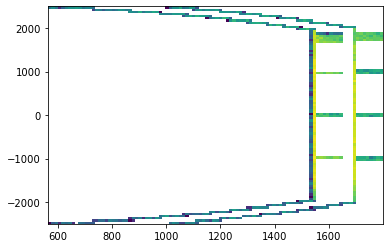

In [17]:
plt.hist2d(np.sqrt(flat_df_raw['xp_pri']**2+flat_df_raw['yp_pri']**2), flat_df_raw['zp_pri'],  bins=[100, 100], norm=LogNorm())
plt.show()

In [ ]:
file_prefix = ''

year = 3.154e7  #seconds
mass_fv = 5.0
energy_binning = np.linspace(2000, 3000, 101)

fig, ax = plt.subplots(figsize=(8, 6))
for isotope in ['U238', 'Th232']:
    background_hist = Histdd(bins=[energy_binning])
    binwidth = background_hist.bin_centers(0)[1]-background_hist.bin_centers(0)[0]
    errors=np.zeros_like(background_hist.bin_centers(0))
    for key, volume in act_dict.items():
        all_dfs = []
    
        # Search for all files matching the pattern for this key + isotope
        file_pattern = f'/scratch/midway2/jpienaar/hermeticTPC/{key}_{isotope}_*.npy'
        matched_files = sorted(glob.glob(file_pattern))
        
        for filepath in matched_files:
            filename = os.path.basename(filepath)
    
            # Use regex to extract serial number (handles zero-padding)
            match = re.match(rf'{re.escape(file_prefix)}{re.escape(key)}_{re.escape(isotope)}_(\d+)\.npy', filename)
            if match:
                serial_num = int(match.group(1))
                if serial_num > max_index:
                    continue
    
                # Load and collect DataFrame
                #try:
                iso_vol_df = np.load(filepath, allow_pickle=True)
                #except:
                    #print(filepath)
                iso_vol_df = pd.DataFrame(iso_vol_df, columns=['xpos', 'ypos', 'zpos', 'escatter', 'multis'])
                all_dfs.append(iso_vol_df)
                
            else:
                print(f"Skipping file (name format doesn't match): {filename}")
    
        # Concatenate all matching DataFrames
        if not all_dfs:
            print(f"No files found for key {key}, isotope {isotope}")
            continue

        file_loaded_counter = len(all_dfs)
        full_iso_vol_df = pd.concat(all_dfs, ignore_index=True)
    
        # Apply masking as before
        mask = (full_iso_vol_df['multis'] == False)
        mask &= (full_iso_vol_df['xpos'] ** 2 + full_iso_vol_df['ypos'] ** 2 < 475 ** 2)
        #mask &= (full_iso_vol_df['zpos'] < 1350) & (full_iso_vol_df['zpos'] > -1350)
        mask &= (full_iso_vol_df['escatter'] > 2000) & (full_iso_vol_df['escatter'] < 3000)
    
        # Histogram calculation
        temp_hist = Histdd(
            energy_res(full_iso_vol_df[mask]['escatter'].astype(float), 0.317, 1.7),
            bins=[energy_binning],
            )

        temp_errors = np.sqrt(temp_hist.histogram)
    
        if scale_dict[key][isotope] > 0:
            print(isotope, key, file_loaded_counter, len(full_iso_vol_df[mask]['escatter']))
            background_hist.histogram += (
                (temp_hist.histogram / (1000 * scale_dict[key][isotope]* file_loaded_counter  * binwidth * mass_fv) * year ))
            errors += (temp_errors * (1 / (1000 * scale_dict[key][isotope]* file_loaded_counter  * binwidth * mass_fv) * year ))
    plt.errorbar(background_hist.bin_centers(0), background_hist.histogram, yerr = errors, marker = "o", label = isotope)
    #plt.yscale('log')

plt.legend()
plt.ylabel('Counts [counts/(tonne.year.keV)]')
plt.xlabel('Energy [keV]')
plt.ylim(0.01, 10)
plt.xlim(2000, 2800)
plt.yscale('log')
#plt.savefig("Full_5t_log.png", dpi=300)
plt.show()
